In [1]:
import sys
sys.path.append('..')
from simtools import Strip, pattern_ascii

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import discretisedfield as df
import discretisedfield.tools as dft

In [3]:
# taken from: https://jfly.uni-koeln.de/color/
colors = [[0.        , 0.        , 0.        ],
          [0.90196078, 0.62352941, 0.        ],
          [0.3372549 , 0.70588235, 0.91372549],
          [0.        , 0.61960784, 0.45098039],
          [0.8       , 0.4745098 , 0.65490196],
          [0.        , 0.44705882, 0.69803922],
          [0.83529412, 0.36862745, 0.        ],
          [0.94117647, 0.89411765, 0.25882353]]

This notebook contains a few long-running simulations. To speed up the notebook execution this data is pre-computed and stored in the repository in the `data` directory. To recompute all data in this notebook set the variable `recompute` in the next cell to `True`.

In [4]:
recompute = False

# Mimimisation scheme

In [5]:
strip = Strip(length=100e-9,
              width=100e-9,
              htop=10e-9,
              hbottom=20e-9,
              dirname='data/sup',
              initpattern='i')

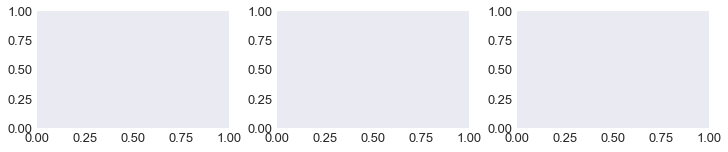

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2), constrained_layout=True)

In [7]:
scalar_opts = dict(clim=[-1,1], colorbar=False, cmap='coolwarm')

In [8]:
strip.system.m.orientation.plane('y').z.mpl(ax=axs[0], scalar_kw=scalar_opts)

In [9]:
strip.min_drive(fixed=True)

Running OOMMF (ExeOOMMFRunner)[2022/03/07 09:28]... (4.3 s)


In [10]:
strip.system.m.orientation.plane('y').z.mpl(ax=axs[1], scalar_kw=scalar_opts)

In [11]:
strip.min_drive()

Running OOMMF (ExeOOMMFRunner)[2022/03/07 09:28]... (3.2 s)


In [12]:
strip.system.m.orientation.plane('y').z.mpl(ax=axs[2], scalar_kw=scalar_opts)

In [13]:
axs[1].set_ylabel(None)
axs[2].set_ylabel(None);

In [14]:
for i, label in [[0, 'a'], [1, 'b'], [2, 'c']]:
    axs[i].annotate(label, xy=(0, 1), xycoords='axes fraction', xytext=(0,5), textcoords='offset points', fontsize='xx-large', fontweight='bold')
    
im = axs[0].get_images()[0]
fig.colorbar(im, ax=axs, label=r'$m_z$', shrink=.7, aspect=10, fraction=.01)

In [15]:
axs[1].add_patch(plt.Rectangle((25, 7.5), 52.5, 2.5, facecolor='none', edgecolor='yellow', lw=2))
axs[1].add_patch(plt.Rectangle((25, -20), 52.5, 2.5, facecolor='none', edgecolor='yellow', lw=2))

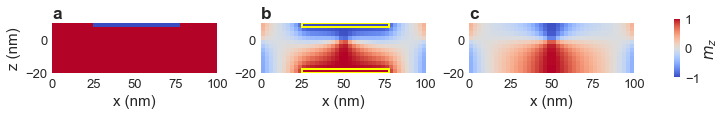

In [16]:
fig

# Subregions

In [17]:
strip = Strip(length=250e-9,
              width=100e-9,
              htop=10e-9,
              hbottom=20e-9,
              dirname='data/sup',
              initpattern='io')

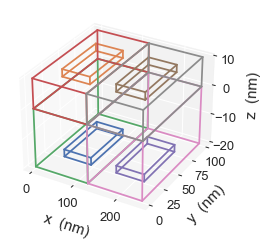

In [18]:
strip.system.m.mesh.mpl_subregions(figsize=(10, 4))

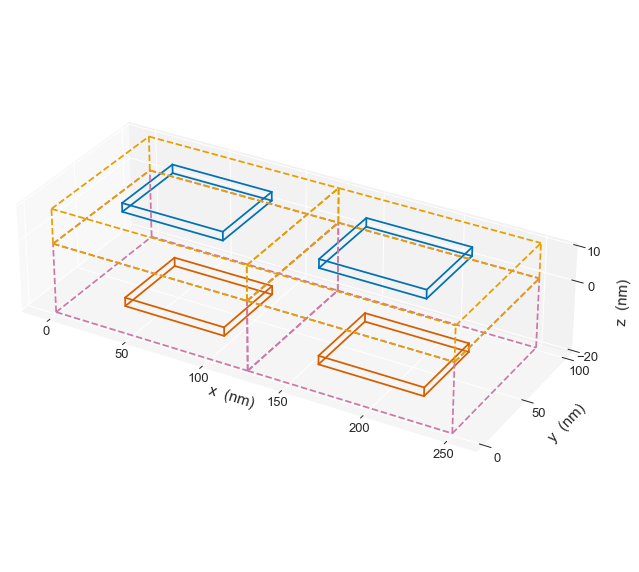

In [19]:
fig = plt.figure(figsize=(10, 30))#, constrained_layout=True)
ax = fig.add_subplot(111, projection='3d', box_aspect=(25, 10, 6))
for sr, linestyle, ci, in zip(strip.system.m.mesh.subregions.values(),
                              ['-', '-', '--', '--', '-', '-', '--', '--'],
                              [6, 5, 4, 1, 6, 5, 4, 1]):
    sr.mpl(ax=ax, linestyle=linestyle, color=colors[ci])
ax.set_yticks([0, 50, 100])
ax.set_zticks([-20, 0, 10]);

# Precision

The simulation for 1 nm cell size takes relatively long (estimate: ~1 hour on 4 cpu cores) so by default we load precomputed data from files.

In [20]:
if recompute:
    pattern = pattern_ascii('B')
    strip_50 = Strip(
        length=160e-9*len(pattern),
        width=100e-9,
        htop=10e-9,
        hbottom=20e-9,
        dirname='data/sup',
        initpattern=pattern,
        cell=(5e-9, 5e-9, 5e-9))
    strip_50.min_drive(fixed=True)
    strip_50.min_drive()

    pattern = pattern_ascii('B')
    strip_25 = Strip(
        length=160e-9*len(pattern),
        width=100e-9,
        htop=10e-9,
        hbottom=20e-9,
        dirname='data/sup',
        initpattern=pattern,
        cell=(2.5e-9, 2.5e-9, 2.5e-9))
    strip_25.min_drive(fixed=True)
    strip_25.min_drive()

    pattern = pattern_ascii('B')
    strip_10 = Strip(
        length=160e-9*len(pattern),
        width=100e-9,
        htop=10e-9,
        hbottom=20e-9,
        dirname='data/sup',
        initpattern=pattern,
        cell=(1e-9, 1e-9, 1e-9))
    strip_10.min_drive(fixed=True)
    strip_10.min_drive()

    fields = [strip_50.system.m, strip_25.system.m, strip_10.system.m]
else:
    fields = [df.Field.fromfile('../data/cellsize/50.hdf5'),
              df.Field.fromfile('../data/cellsize/25.hdf5'),
              df.Field.fromfile('../data/cellsize/10.hdf5')]

In [21]:
def counting(field):
    """Compute convolution S(x) and round to integer."""
    F_div = dft.emergent_magnetic_field(field.orientation).div
    F_int = df.integral(F_div * df.dV, direction='yz').integral(direction='x', improper=True)
    bp_count = (F_int / (4 * np.pi)).array.squeeze()
    return bp_count, bp_count.round()

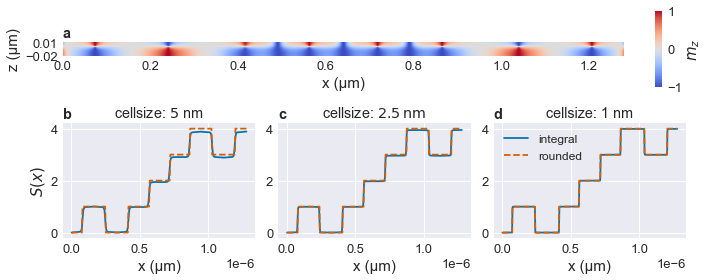

In [22]:
fig, axs = plt.subplot_mosaic('''aaa
                                 bcd''',
                              figsize=(10, 4), gridspec_kw={'height_ratios': [1, 1.5]})

fields[2].orientation.plane('y').z.mpl.scalar(ax=axs['a'], cmap='coolwarm', clim=(-1, 1), colorbar=False)
chbar = plt.colorbar(axs['a'].images[0], ax=axs['a'], fraction=0.05, aspect=10)
chbar.ax.set_ylabel('$m_z$')
axs['a'].annotate('a', xy=(0, 1), xycoords='axes fraction', xytext=(0, 5), textcoords='offset points', fontweight='bold', fontsize='x-large')
axs['a'].set_yticks([-0.02, 0.01])
axs['a'].set_ylabel('z (μm)')
axs['a'].set_xlabel('x (μm)')

for i, field, title in zip('bcd', fields, [r'$5$ nm', r'$2.5\,\mathrm{nm}$', '1 nm']):
    ax = axs[i]
    integral, rounded = counting(field)
    xx = np.fromiter(field.mesh.axis_points('x'), dtype=float)
    ax.plot(xx, integral, label='integral', c=colors[5])
    ax.plot(xx, rounded, '--', label='rounded', c=colors[6])
    ax.set_title(rf'cellsize: {title}', fontdict={'fontsize': 'x-large'})
    ax.grid()
    ax.set_xlabel(r'x (μm)')
    ax.annotate(i, xy=(0, 1), xycoords='axes fraction', xytext=(0, 5), textcoords='offset points', fontweight='bold', fontsize='x-large')

axs['b'].set_ylabel(r'$S(x)$')
axs['d'].legend()
fig.tight_layout()